In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import pickle
import warnings
import shutil

In [2]:
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
warnings.filterwarnings('ignore')

In [15]:
data_dir = "./Music Genre Classification/"  
data_dir2 = "./Data copy/genres_original/"

In [6]:
# Load the saved LabelEncoder and Scaler
with open('encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [7]:
# CNN model
def cnn_model(input_shape, num_classes):
    model_cnn = Sequential()

    # 1st conv layer
    model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model_cnn.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model_cnn.add(BatchNormalization())


    # 2nd conv layer
    model_cnn.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.0001)))
    model_cnn.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Dropout(0.3))

    # 3rd conv layer
    model_cnn.add(Conv2D(128, (2, 2), activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.0001)))
    model_cnn.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Dropout(0.3))

    # flatten output and feed it into dense layer
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.0001)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Dropout(0.3))

    # output layer
    model_cnn.add(Dense(num_classes, activation='softmax'))
    
    return model_cnn

In [8]:
cnn_model(input_shape=(13, 130, 1), num_classes=10).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 64, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 64, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 62, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 31, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 30, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 15, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 15, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 15, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,298 (1.15 MB)

 Trainable params: 299,594 (1.14 MB)

 Non-trainable params: 704 (2.75 KB)

In [9]:
class ModelPredictior():
    def __init__(self, model_path, input_shape, num_classes, n_mfccs=13, n_fft=1024, hop_length=512):
        # model path for buiding model
        self.model_path = model_path
        self.input_shape = input_shape
        self.n_mfccs = n_mfccs
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_classes = num_classes
        
    # Build DNN
    def build_dnn_model(self):
        model = build_model(self.input_shape, self.num_classes)
        return model
    
    # Build CNN
    def build_cnn_model(self):
        model = cnn_model(self.input_shape, self.num_classes)
        return model
    
    def predict(self, filepath, n_splits=10, hop=2):
        # Load File path and model weights
        try:
            # Load song
            audio, sr = sf.read(filepath)
            # Calulate duration
            duration = int(audio.shape[0] / sr)
            # Window size for spliting the song into smaller bits
            frame = int(duration / n_splits)
            # build and load model weights
            model = self.build_dnn_model()
            model.load_weights(self.model_path)
        except Exception as e:
            return
        
        # cache genre predictions
        genre_predictions = {}
 
        for i in range(0, duration, hop):
            # Extract MFCC of a window
            MFCC = librosa.feature.mfcc(y=audio[i*sr: (i+frame)*sr], n_mfcc=self.n_mfccs, n_fft=self.n_fft, hop_length=self.hop_length)
            # Calculate Mean MFCC across time axis
            MFCC = np.mean(MFCC, axis=1)
            # Add an axis for giving model as a batch size of 1
            MFCC = MFCC[np.newaxis, :]
            # scale model using Min Max scaler using all ready used in training
            MFCC = scaler.transform(MFCC)
            # predict
            prediction = model.predict(MFCC,  verbose=0)
            prediction = np.argmax(prediction, axis=1)
            genre = label_encoder.inverse_transform(prediction)
            # update frequency of genre predicted
            genre_predictions[genre[0]] = genre_predictions.get(genre[0], 0) + 1
    
        return genre_predictions
    
    
    def cnn_predict(self, filepath, n_splits=10, hop=2):
        try:
            # Load song
            audio, sr = sf.read(filepath)
            # Calulate duration
            duration = int(audio.shape[0] / sr)
            # Window size for spliting the song into smaller bits
            frame = int(duration / n_splits)
            # build and load model weights
            model = self.build_cnn_model()
            model.load_weights(self.model_path)
        except Exception as e:
            print(e)
            return
        
        
        genre_predictions = {}
        for i in range(0, duration, hop):
            try:
                # Extract model
                MFCC = librosa.feature.mfcc(y=audio[i*sr: (i+frame)*sr], n_mfcc=self.n_mfccs, n_fft=self.n_fft, hop_length=self.hop_length)
                # add a axis at beginning for batch size and other axis for CNN num channels 
                MFCC = MFCC[np.newaxis, :, :, np.newaxis]
                # predict
                prediction = model.predict(MFCC,  verbose=0)
                prediction = np.argmax(prediction, axis=1)
                genre = label_encoder.inverse_transform(prediction)
                # update frequency of genre predicted
                genre_predictions[genre[0]] = genre_predictions.get(genre[0], 0) + 1
            except Exception as e:
                continue
        
        return genre_predictions
        

In [27]:
cnn_model_predictor = ModelPredictior("cnn_model.h5", (13, 130, 1), 10)

In [ ]:
test_dir = './test_songs' # Directory to store test files

In [28]:
def max_freq_genre(genres):
    max_freq = 0
    max_genre = ''
    for genre in genres.keys():
        if genres[genre] > max_freq:
            max_freq = genres[genre]
            max_genre = genre
    return max_genre

In [29]:
test_dir2 = './test_songs2'

In [22]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for genre in genres:
    genre_dir = os.path.join(test_dir2, genre)
    if not os.path.exists(genre_dir):
        os.makedirs(genre_dir)
    for i in range(20):
        if i < 10:
            filepath = f'./Data copy/genres_original/{genre}/{genre}.0000{i}.wav'
        else: 
            filepath = f'./Data copy/genres_original/{genre}/{genre}.000{i}.wav'
        shutil.copy(filepath, genre_dir)

Generated. Test. data. by. random. sampling. from. given. data

In [ ]:
# # randomly sample 20 full-songs from the given data set
# import random


# # Ensure the 'test_songs' directory exists, if not create it
# if not os.path.exists(test_dir):
#     os.makedirs(test_dir)

# test_files = []
# n_samples = 20
# for path, subdirs, files in os.walk(data_dir):
#     try:
#         random_files = random.sample(files, n_samples)
#         for file in random_files:
#             filepath = os.path.join(path, file)
#             if file.endswith(".wav"):
#                 test_files.append(filepath)  
#                 genre = os.path.basename(path)
#                 # shutil.copy(filepath, test_dir)   
#                 genre_dir = os.path.join(test_dir, genre)
#                 if not os.path.exists(genre_dir):
#                     os.makedirs(genre_dir)
#                 # Copy the selected file to the genre subdirectory
#                 shutil.copy(filepath, genre_dir)
#                 test_files.append(filepath)
#     except Exception as e:
#         print(e)
#         continue
                    

Sample larger than population or is negative


In [ ]:
actual = []; predicted = []
for path, subdirs, files in os.walk(test_dir2):
    for file in files:
        filepath = os.path.join(path, file)
        genre = os.path.basename(path)
        actual.append(genre)
        predicted_genres = cnn_model_predictor.cnn_predict(filepath)
        predicted_genre = max_freq_genre(predicted_genres)
        predicted.append(predicted_genre)
        


Classification Report:
               precision    recall  f1-score   support

                   0.00      0.00      0.00         0
       blues       0.75      0.45      0.56        20
   classical       0.74      1.00      0.85        20
     country       0.33      0.55      0.42        20
       disco       0.54      0.65      0.59        20
      hiphop       0.86      0.60      0.71        20
        jazz       0.67      0.60      0.63        20
       metal       0.82      0.90      0.86        20
         pop       0.94      0.75      0.83        20
      reggae       0.81      0.65      0.72        20
        rock       0.29      0.20      0.24        20

    accuracy                           0.64       200
   macro avg       0.61      0.58      0.58       200
weighted avg       0.67      0.64      0.64       200



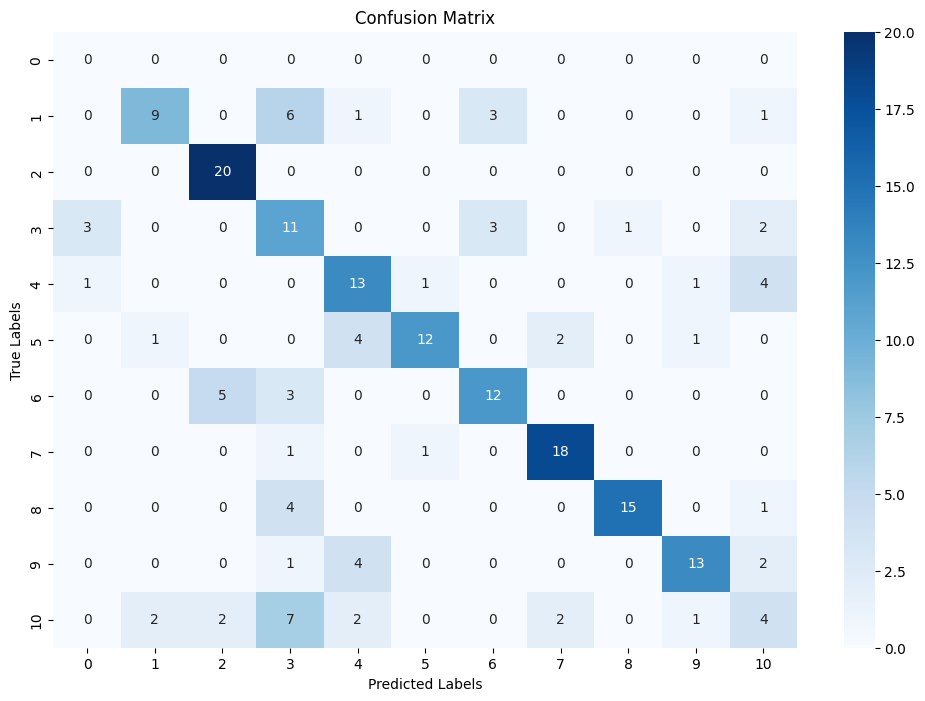

In [31]:

# Generate classification report
report = classification_report(actual, predicted,)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true=actual, y_pred=predicted)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
